In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision

In [2]:
!unzip /kaggle/input/notebook7208af8a7a/_output_.zip -d /kaggle/working/data > /dev/null 2>&1

In [3]:
print(os.listdir('/kaggle/working/data/results/images'))

['7', '2', '9', '8', '1', '4', '6', '0', '5', '3']


In [4]:
new_size = 448
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
device

device(type='cuda', index=0)

In [5]:
path_to_imgs = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images'
path = os.path.join(path_to_imgs, r'train_images')
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bb_file = '/kaggle/input/textocr-text-extraction-from-images-dataset'
path_to_bounding_boxes = os.path.join(path_to_bb_file, r'TextOCR_0.1_train.json')
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [6]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


In [7]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[-2:]
    
    if h > w:
        pad = h - w
        img = transforms.Pad((0, 0, pad, 0))(img)
    elif w > h:
        pad = w - h
        img = transforms.Pad((0, 0, 0, pad))(img)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size,transforms.InterpolationMode.BICUBIC , antialias=True)(img)
    return img

In [8]:
def pre_process_image(img, size=new_size):
    h, w = img.shape[-2:]
    max_shape = max(h, w)
    ratio = size / max_shape
    img = pad_img(img)
    img = resize_img(img, size)
    return img, ratio


In [9]:
def make_it_cv2(img):
    img = img.permute(1, 2, 0)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [10]:
def crop_img(img, x1, y1, x2, y2):
    img = img[:, y1:y2, x1:x2]
    return img

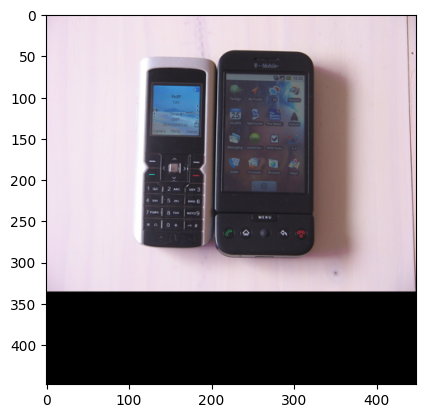

In [11]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]

img_idx = 86
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = read_image(files[img_idx])
img, ratio = pre_process_image(img)
plt.imshow(make_it_cv2(img))
idx = -1

In [12]:
from torchvision.transforms import v2

def pre_process_text_box(img):
#     hw = 32/96
#     h, w = img.shape[-2:]
#     if h/w > hw:
#         w_pad = int(h/hw) - w
#         left_pad = w_pad//2
#         right_pad = w_pad - left_pad
#         img = transforms.Pad((left_pad, 0, right_pad, 0))(img)
#     else:
#         h_pad = int(w*hw) - h
#         up_pad = h_pad//2
#         down_pad = h_pad - up_pad
#         img = transforms.Pad((0, up_pad, 0, down_pad))(img)
    img = transforms.Resize((32, 128), antialias=True)(img)
    img = v2.Grayscale()(img)
    img = img / 255.
    return img

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

tensor([[[0.4588, 0.4588, 0.4588,  ..., 0.4824, 0.4824, 0.4824],
         [0.4588, 0.4588, 0.4588,  ..., 0.4824, 0.4824, 0.4824],
         [0.4588, 0.4588, 0.4588,  ..., 0.4824, 0.4824, 0.4824],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.4863, 0.4863, 0.4863],
         [0.4784, 0.4784, 0.4784,  ..., 0.4863, 0.4863, 0.4863],
         [0.4784, 0.4784, 0.4784,  ..., 0.4863, 0.4863, 0.4863]]])
VoIP


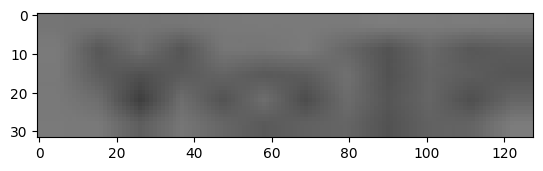

In [13]:
idx += 1
ann = bounding_boxes['anns'][img_anns[idx]]
points = ann['bbox']
x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
box_img = crop_img(img, x1, y1, x2, y2)
# box_img = transform(box_img)
box_img = pre_process_text_box(box_img)
print(box_img)
box_img = make_it_cv2(box_img)
plt.imshow(box_img)
print(ann['utf8_string'])

In [14]:
chars = set()
for img_idx in range(len(img_ids)):
    img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    for idx in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[idx]]
        for char in ann['utf8_string']:
            chars.add(char)
pad_token = '█'
start_token = '├'
end_token = '┤'
chars.add(pad_token)
chars.add(start_token)
chars.add(end_token)
vocab = sorted(list(chars))
print(len(vocab))
print(vocab)

903
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¥', '§', '©', '«', '¬', '®', '°', '±', '²', '³', 'µ', '·', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'ċ', 'Č', 'č', 'Đ', 'Ē', 'ē', 'Ĕ', 'ĕ', 'Ė', 'ė', 'Ę',

In [15]:
chtoi = {ch: i for i, ch in enumerate(vocab)}
itoch = {i: ch for i, ch in enumerate(vocab)}

def encode(s: str):
    encoded = []
    for c in s:
        encoded.append(chtoi[c])
    return encoded

def decode(d: list):
    decoded = ""
    for i in d:
        if type(i) == torch.Tensor:
            decoded += itoch[i.item()]
        else:
            decoded += itoch[i]
    return decoded

pad_token_en = encode(pad_token)[0]
print(encode("heyyyy"))
print(decode(encode("heyyyy")))

[71, 68, 88, 88, 88, 88]
heyyyy


In [16]:
files = np.array(files)
img_ids = np.array(img_ids)
max_point_in_slice = 1
os.chdir('/kaggle')
os.mkdir('tmp')
os.chdir('tmp')
os.mkdir('train')
os.mkdir('test')

data_set_size = 17295
train_real_size = 16000
test_idxs = np.random.choice(data_set_size, data_set_size - train_real_size, replace=False)
train_feature_label = []
test_feature_label = []
num_of_samples_train = 0
num_of_samples_test = 0

num_of_samples = 0
for idx in range(len(files)):
    img_path = files[idx]
    image = read_image(img_path)
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    elif image.shape[0] != 3:
        image = image[:3]
    image, ratio = pre_process_image(image)

    img_anns = bounding_boxes['imgToAnns'][img_ids[idx][:-4]]
    for i in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[i]]
        if len(ann['utf8_string']) > 25 or ann['utf8_string'] == '.':
            continue
        points = ann['bbox']
        x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
        x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        if x2 - x1 < 40 or y2 - y1 < 40:
            continue
        box_img = crop_img(image, x1, y1, x2, y2)
        label = encode(ann['utf8_string'])
        feature = box_img
        if num_of_samples in test_idxs:
            torchvision.io.write_jpeg(feature, os.path.join('test', str(num_of_samples_test)))
            test_feature_label.append((f'test/{num_of_samples_test}', label))
            num_of_samples_test += 1
        else:
            torchvision.io.write_jpeg(feature, os.path.join('train', str(num_of_samples_train)))
            train_feature_label.append((f'train/{num_of_samples_train}', label))
            num_of_samples_train += 1
        print(f'\r{num_of_samples + 1}/{data_set_size}', end='', flush=True)
        num_of_samples += 1
        if num_of_samples >= data_set_size:
            break
    if num_of_samples >= data_set_size:
            break

print()      
with open('/kaggle/working/data/results/gt.txt', 'r') as f:
    data = f.read().splitlines()
    s = 0
    for line in data:
        img_path, text = line.split('\t')
        label = encode(text)
        train_feature_label.append(('/kaggle/working/data/results/' + img_path, label))
        num_of_samples_train += 1
        s += 1


17295/17295


In [17]:
from torchvision import transforms
from torchvision.transforms import v2
import random

# Define a more extensive data augmentation pipeline
def transform(img):
    h, w = img.shape[-2:]
    
    # Randomly adjust brightness and contrast
    img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
    
    
    # Randomly apply Gaussian blur with a 5% probability
    if random.random() < 0.1:
        img = transforms.GaussianBlur(5, sigma=(0.1, 2.0))(img)
    
    min_crop = 0.8
    rand_floats = (min_crop - 1.0) * torch.rand(2) + 1.0
    img = transforms.RandomCrop((int(h*rand_floats[0]), int(w*rand_floats[0])))(img)
    
    img = v2.RandomPhotometricDistort()(img)
    
    if random.random() < 0.1:
        r = random.random()
        if r < 0.333:
            img = torch.rot90(img, k=1, dims=[1, 2])
        elif 0.333 < r < 0.666:
            img = torch.rot90(img, k=2, dims=[1, 2])
        else:
            img = torch.rot90(img, k=3, dims=[1, 2])
#     img = v2.RandomPerspective()(img)
    
    return img

In [18]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random


class ImageDataset(Dataset):
    def __init__(self, size, train):
        self.size = size
        self.train = train
        self.max_seq_len = 27
        self.pad_token = encode(pad_token)[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.train:
            feature, label_output = train_feature_label[idx]
        else:
            feature, label_output = test_feature_label[idx]
        feature = read_image(feature)
        label_output = torch.tensor(label_output, dtype=torch.long)
        feature = transform(feature)
        feature = pre_process_text_box(feature)
        de_output = label_output
        de_output = torch.cat([label_output, torch.tensor(encode(end_token), dtype=torch.long)], dim=0)
        if de_output.shape[0] < self.max_seq_len:
            de_output = torch.cat([de_output, torch.full((self.max_seq_len - len(de_output),), self.pad_token)], dim=0)
        de_input = torch.cat([torch.tensor(encode(start_token), dtype=torch.long), de_output[:-1]], dim=0)
        return feature, de_input, de_output
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_dataset = ImageDataset(num_of_samples_train, True)
test_dataset = ImageDataset(num_of_samples_test, False)

batch_size = 256
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True,
                              worker_init_fn=seed_worker,
                              generator=g)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=os.cpu_count(),
                             pin_memory=True,
                             worker_init_fn=seed_worker,
                             generator=g)
print(len(train_dataloader))
print(len(test_dataloader))

454
6


├selected┤█████████████████
selected┤██████████████████
torch.Size([1, 32, 128])


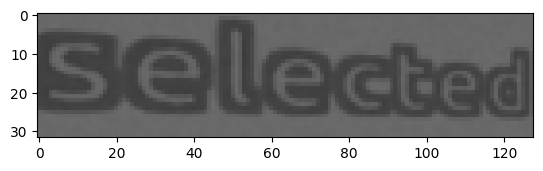

In [19]:
feature, de_input, de_output = next(iter(train_dataloader))
print(decode(de_input[0]))
print(decode(de_output[0]))
print(feature[0].shape)
plt.imshow(make_it_cv2(feature[0]))

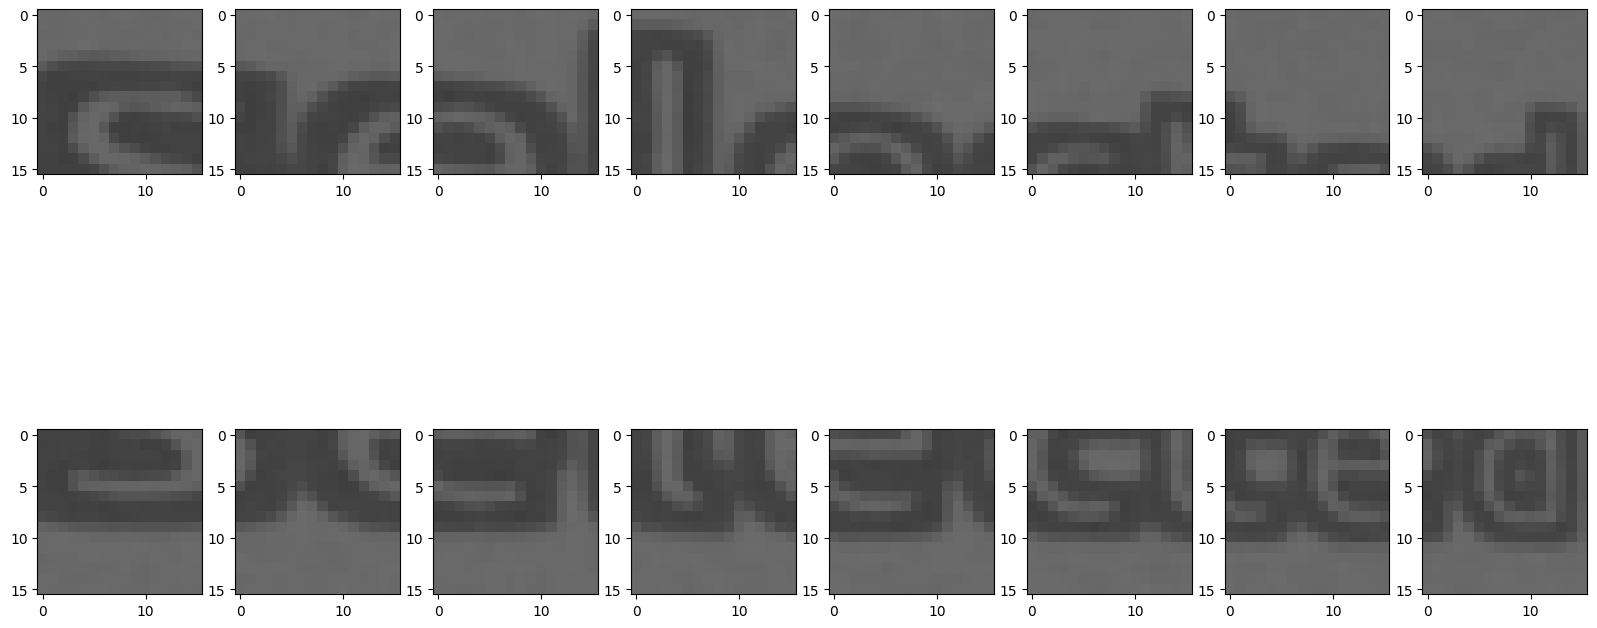

In [20]:
b, c, h, w = feature.shape
ph, pw = 16, 16
nh, nw = h // ph, w // pw
x = feature
x = torch.reshape(x, (b, c, nh, ph, nw, pw))
x = torch.permute(x, (0, 1, 2, 4, 3, 5))
fig, axs = plt.subplots(nh, nw, figsize=(20, 10))
idx = -1
for i in range(nh):
    for j in range(nw):
        patch = x[0, 0, i, j, :, :].view(1, ph, pw)
        axs[i, j].imshow(make_it_cv2(patch))

In [21]:
dropout = 0.4

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

class Patches(nn.Module):
    def __init__(self, ph, pw, in_ch):
        super(Patches, self).__init__()
        self.ph = ph
        self.pw = pw
        self.ln = nn.LayerNorm(ph*pw*in_ch)
        
    def forward(self, x):
        b, c, h, w = x.shape
        nh, nw = h // self.ph, w // self.pw
        x = torch.reshape(x, (b, c, nh, self.ph, nw, self.pw))
        x = torch.permute(x, (0, 2, 4, 3, 5, 1))
        x = torch.reshape(x, [b, nh * nw, self.ph * self.pw * c])
        x = self.ln(x)
        return x
    
class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed):
        super(CharacterEmbedding, self).__init__()
        self.block_size = block_size
        self.token_embed_tab = nn.Embedding(vocab_size, n_embed)
        self.register_buffer(
                    "positional_embeddings",
                    get_positional_embeddings(block_size, n_embed),
                    persistent=False,
                )
        
    def forward(self, x):
        # x shape: (batch, block_size)
        B, T = x.shape
        x = self.token_embed_tab(x) # shape: (batch, block_size, n_embed)
        position_embed = self.positional_embeddings[:T, :]
        return x + position_embed.repeat(x.shape[0], 1, 1)
    
class PatchEmbedding(nn.Module):
    def __init__(self, n_patches, patch_size, n_embed, add_patches=0):
        super(PatchEmbedding, self).__init__()
        self.n_patches = n_patches
        self.token_embed_tab = nn.Linear(patch_size, n_embed)
        self.positional_embeddings = nn.Parameter(torch.randn(1, n_patches + add_patches + 1, n_embed)*0.02)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, n_embed))
        self.dropout = nn.Dropout(0.)
        if add_patches > 0:
            self.add_patches = nn.Parameter(torch.zeros(1, add_patches, n_embed))
        else:
            self.add_patches = None
        
    def forward(self, x):
        B = x.shape[0]
        x = self.token_embed_tab(x)
        cls_tok = self.cls_token.expand([B, -1, -1])
        x = torch.cat([cls_tok, x], dim=1)
        if self.add_patches != None:
            new_patches = self.add_patches.expand([B, -1, -1])
            x = torch.cat([x, new_patches], dim=1)
        x = x + self.positional_embeddings.repeat(B, 1, 1)
        x = self.dropout(x)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, block_size, n_embed, apply_mask, cross=False):
        super(MultiHeadAttention, self).__init__()
        self.single_head_size = n_embed // n_heads
        self.n_heads = n_heads
        self.out = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)
        self.apply_mask = apply_mask
        self.attn_weights = None
        if apply_mask:
            self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))
        self.cross = cross
        if cross:
            self.kv = nn.Linear(n_embed, 2*n_embed, bias=False)
            self.q = nn.Linear(n_embed, n_embed, bias=False)
        else:
            self.qkv = nn.Linear(n_embed, 3*n_embed, bias=False)
        
    def forward(self, x, kv=None):
        B, T, C = x.shape
        if self.cross:
            k, v = self.kv(kv).reshape(B, kv.shape[1], 2, self.n_heads, self.single_head_size).permute(2, 0, 3, 1, 4).unbind(0) # (2, B, n_heads, T, head_dim)
            q = self.q(x).reshape(B, T, self.n_heads, self.single_head_size).permute(0, 2, 1, 3)
        else:
            q, k, v = self.qkv(x).reshape(B, T, 3, self.n_heads, self.single_head_size).permute(2, 0, 3, 1, 4).unbind(0)
        q = q * (self.single_head_size ** -0.5)
        attn = q @ k.transpose(-2, -1)
        if self.apply_mask:
            attn = attn.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = attn @ v
        x = x.transpose(1, 2).reshape(B, T, C)
        x = self.dropout(self.out(x))
        return x
    
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super(FeedForward, self).__init__()
        layers = [nn.Linear(n_embed, 4*n_embed),
                  nn.GELU(),
                  nn.Linear(4*n_embed, n_embed),
                  nn.Dropout(dropout)]
        layer_modules = nn.ModuleList(layers)
        self.net = nn.Sequential(*layer_modules)
        
    def forward(self, x):
        return self.net(x)

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.15):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output
    
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, block_size, n_embed):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(n_heads, block_size, n_embed, False)
        self.fw = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.layer_scale1 = nn.Parameter(1e-5 * torch.ones(n_embed))
        self.layer_scale2 = nn.Parameter(1e-5 * torch.ones(n_embed))
        self.drop_path = DropPath()
        
    def forward(self, x):
        x = x + self.drop_path(self.layer_scale1*self.self_attention(self.ln1(x)))
        x = x + self.drop_path(self.layer_scale2*self.fw(self.ln2(x)))
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, block_size, n_embed):
        super(DecoderBlock, self).__init__()
        self.masked_self_attention = MultiHeadAttention(n_heads, block_size, n_embed, True)
        self.cross_attention = MultiHeadAttention(n_heads, block_size, n_embed, False, True)
        self.fw = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)
        layer_scale = False
        self.layer_scale1 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.layer_scale2 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.layer_scale3 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.drop_path = DropPath()
        
    def forward(self, x):
        x, kv = x[0], x[1]
        x = x + self.drop_path(self.layer_scale1(self.masked_self_attention(self.ln1(x))))
        x = x + self.drop_path(self.layer_scale2(self.cross_attention(self.ln2(x), kv)))
        x = x + self.drop_path(self.layer_scale3(self.fw(self.ln3(x))))
        return (x, kv)
    
class Encoder(nn.Module):
    def __init__(self, N, n_heads, block_size, n_embed):
        super(Encoder, self).__init__()
        self.blocks = [EncoderBlock(n_heads, block_size, n_embed) for _ in range(N)]
        self.blocks = nn.ModuleList(self.blocks)
        self.blocks = nn.Sequential(*self.blocks)
        
    def forward(self, x):
        return self.blocks(x)
    
class Decoder(nn.Module):
    def __init__(self, N, n_heads, block_size, n_embed):
        super(Decoder, self).__init__()
        self.blocks = [DecoderBlock(n_heads, block_size, n_embed) for _ in range(N)]
        self.blocks = nn.ModuleList(self.blocks)
        self.blocks = nn.Sequential(*self.blocks)
    
    def forward(self, x, kv):
        return self.blocks((x, kv))
    
class TrOcr(nn.Module):
    def __init__(self):
        super(TrOcr, self).__init__()
        n_embed = 384
        L_en = 12
        L_de = 4
        n_heads = 12
        patch_h = 16
        patch_w = 16
        h = 128
        w = 32
        ch = 1
        self.seq_len = 27
        n_patches = w*h//(patch_h*patch_w)
        patch_size = w*h*ch//n_patches
        add_patches = 0
        self.to_patches = Patches(patch_h, patch_w, ch)
        self.patch_embedding = PatchEmbedding(n_patches, patch_size, n_embed, add_patches)
        self.token_embedding = CharacterEmbedding(len(vocab), self.seq_len, n_embed)
        self.encoder = Encoder(L_en, n_heads, n_patches, n_embed)
        self.decoder = Decoder(L_de, n_heads, self.seq_len, n_embed)
        self.ln = nn.LayerNorm(n_embed)
        self.last_layer = nn.Linear(n_embed, len(vocab))
        
    def forward(self, x, de_input):
        en_output = self.to_patches(x)
        en_output = self.patch_embedding(en_output)
        en_output = self.encoder(en_output)
        de_input = self.token_embedding(de_input)
        de_output = self.decoder(de_input, en_output)
        output = self.ln(de_output[0])
        output = output[:, :self.seq_len]
        B, T, E = output.shape
        output = output.reshape(B*T, E)
        output = self.last_layer(output).view(B, T, len(vocab))
        return output
  


In [22]:
 class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
    
    def forward(self, prediction, target):
        prediction = prediction[:, :target.shape[1]]
        B, T, C = prediction.shape
        prediction = prediction.reshape(B*T, C)
        target = target.reshape(B*T)
        loss = nn.functional.cross_entropy(prediction, target, ignore_index=encode(pad_token)[0], reduction='mean')
        return loss

In [23]:
def show_progress(epoch, step, total_steps, loss, added_text='', width=30, bar_char='█', empty_char='░'):
    print('\r', end='')
    progress = ""
    for i in range(width):
        progress += bar_char if i < int(step / total_steps * width) else empty_char
    print(f"epoch:{epoch + 1} [{progress}] {step}/{total_steps} loss: {loss:.4f}" + added_text, end='')


In [24]:
def trim_batch(batch):
    idxes = (batch != encode(pad_token)[0]).nonzero()
    biggest_idx = torch.max(idxes[:, 1])
    batch = batch[:, :biggest_idx + 1]
    return batch

In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.optim.lr_scheduler import _LRScheduler

class WarmupCosineSchedule(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, t_total):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        super(WarmupCosineSchedule, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [self.last_epoch / max(1, self.warmup_steps) * base_lr for base_lr in self.base_lrs]
        return [0.5 * (1.0 + np.cos(np.pi * (self.last_epoch - self.warmup_steps) / (self.t_total - self.warmup_steps))) * base_lr for base_lr in self.base_lrs]


In [26]:
epochs = 130
import gc
gc.collect()
torch.cuda.empty_cache()
model = TrOcr()
model = nn.DataParallel(model, device_ids=[0])
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
loss = Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = WarmupCosineSchedule(optimizer, warmup_steps=5, t_total=epochs)

epoch = 0
best_val_acc = 0

31.547399 M parameters


In [27]:
@torch.no_grad()
def estimate_correct(prediction, target):
    B, T = target.shape
    sum_correct = 0
    prediction = torch.argmax(prediction[:, :T], dim=-1)
    for b in range(B):
        c = 0
        c_t = 0
        for t in range(T):
            if target[b, t] == pad_token_en:
                break
            c_t += 1
            if target[b, t] == prediction[b, t]:
                c += 1
        sum_correct += c / c_t
    return sum_correct / B

In [28]:
losses = []
@torch.no_grad()
def estimate_loss():
    model.eval()
    running_loss = 0.0
    iters = 0
    correct = 0
    for feature, de_input, target in test_dataloader:
        iters += 1
        feature = feature.to(device)
        target = target.to(device)
        de_input = de_input.to(device)
        with torch.autocast('cuda'):
            output = model.forward(feature, de_input)
            loss_val = loss(output, target)
        feature.detach()
        output.detach()
        target.detach()
        de_input.detach()
        running_loss += loss_val.item()
        correct += estimate_correct(output.contiguous(), target.contiguous())
    val_loss = running_loss / iters
    correct /= iters
    losses.append(val_loss)
    model.train()
    return val_loss, correct

@torch.no_grad()
def mean_slope(data, window=10):
    d = np.array(data)
    d = d[-window:]
    x1 = d[:window - 1]
    x2 = d[-(window - 1):]
    return np.mean(x2 - x1)

In [29]:
import time

model.train()
while epoch < epochs:
    running_loss = 0.0
    correct = 0
    start = time.time()
    for i, (feature, de_input, target) in enumerate(train_dataloader):
        feature = feature.to(device)
        de_input = de_input.to(device)
        target = target.to(device)
        with torch.autocast('cuda'):
            output = model.forward(feature, de_input)
            loss_val = loss(output, target)
        model.zero_grad()
        loss_val.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        feature.detach()
        target.detach()
        output.detach()
        de_input.detach()
        with torch.no_grad():
            running_loss += loss_val.item()
            correct += estimate_correct(output.contiguous(), target.contiguous())
            show_progress(epoch, i, len(train_dataloader), running_loss/(i + 1))
    with torch.no_grad():
        correct /= len(train_dataloader)
        val_loss, val_acc = estimate_loss()
        if val_acc > best_val_acc and val_acc > 0.5:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/saved_model.pth') # save model weights
        show_progress(epoch, i, len(train_dataloader), running_loss/(i + 1), f' train acc: {correct:.4f}' + f' val loss: {val_loss:.4f} acc: {val_acc:.4f}' + f' val slope: {mean_slope(losses):.4f} time: {time.time() - start:.4f}')
        print()
    epoch += 1
    scheduler.step()

epoch:1 [█████████████████████████████░] 453/454 loss: 7.0488 train acc: 0.0002 val loss: 7.0775 acc: 0.0000 val slope: 0.0000 time: 248.5414
epoch:2 [█████████████████████████████░] 453/454 loss: 2.8855 train acc: 0.2474 val loss: 2.8451 acc: 0.2243 val slope: 0.0000 time: 245.5441
epoch:3 [█████████████████████████████░] 453/454 loss: 2.5413 train acc: 0.2998 val loss: 2.8458 acc: 0.2292 val slope: 0.0000 time: 245.6087
epoch:4 [█████████████████████████████░] 453/454 loss: 2.4440 train acc: 0.3218 val loss: 2.7040 acc: 0.2904 val slope: 0.0000 time: 247.9448
epoch:5 [█████████████████████████████░] 453/454 loss: 2.3889 train acc: 0.3356 val loss: 2.7825 acc: 0.2686 val slope: 0.0000 time: 245.5295
epoch:6 [█████████████████████████████░] 453/454 loss: 2.3578 train acc: 0.3432 val loss: 2.7681 acc: 0.2876 val slope: 0.0000 time: 245.3981
epoch:7 [█████████████████████████████░] 453/454 loss: 2.3058 train acc: 0.3562 val loss: 2.6633 acc: 0.2955 val slope: 0.0000 time: 242.3010
epoch:

Encoder Decoder model:

    best val loss: 0.6089 - n_embed: 192, l_e=6, l_d=4, heads=3
    best val acc: 0.2552 - n_embed: 192, l_e=6, l_d=4, heads=3
    
new patches resize,  ignore pad token loss:

    best val loss: 2.24 - n_embed: 192, l_e=12, l_d=2, heads=6
    best val acc: 0.35 - n_embed: 192, l_e=12, l_d=2, heads=6
    
new patches resize, ignore pad token loss, cosine learning rate:

    best val loss: 2.5085 - n_embed: 384, l_e=12, l_d=2, heads=6
    best val acc: 0.3729 - n_embed: 384, l_e=12, l_d=2, heads=6
    
new patches resize, ignore pad token loss, cosine learning rate, drop path to all:

    best val loss: 2.4333 - n_embed: 384, l_e=12, l_d=4, heads=12, warmup=15
    best val acc: 0.5384 - n_embed: 384, l_e=12, l_d=4, heads=12, warmup=15

new patches resize, ignore pad token loss, cosine learning rate, drop path to all, + synthtiger dataset:

    best val loss: 1.9 - n_embed: 384, l_e=12, l_d=4, heads=12, warmup=15
    best val acc: 0.6821 - n_embed: 384, l_e=12, l_d=4, heads=12, warmup=15

In [30]:
print(best_val_acc)

0.7309456806824323


In [31]:
def trim_pad(s):
    idx = s.index(pad_token, 1)
    return s[:idx]

In [32]:
checkpoint = torch.load('/kaggle/working/saved_model.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [33]:
# make the image divisible by the patch size
def plot_attn(fig):
    img = test_feature[0]
    patch_size_w = 16
    patch_size_h = 16
    w, h = img.shape[1] - img.shape[1] % patch_size_w, img.shape[2] - img.shape[2] % patch_size_h
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size_w
    h_featmap = img.shape[-1] // patch_size_h
    shape = model.module.decoder.blocks[0].cross_attention.attn_weights.shape
    attentions = torch.zeros(shape)
    for i in range(len(model.module.decoder.blocks)):
        attentions += model.module.decoder.blocks[i].cross_attention.attn_weights
    attentions = torch.tensor(attentions).detach()

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=(patch_size_w, patch_size_h), mode='bilinear')[0].cpu().numpy()

    n_heads = attentions.shape[0]
    fig.imshow(img.cpu()[0][0])
    fig.imshow(np.mean(attentions, 0), alpha=0.7)

/tmp/ipykernel_26/2992149040.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attentions = torch.tensor(attentions).detach()


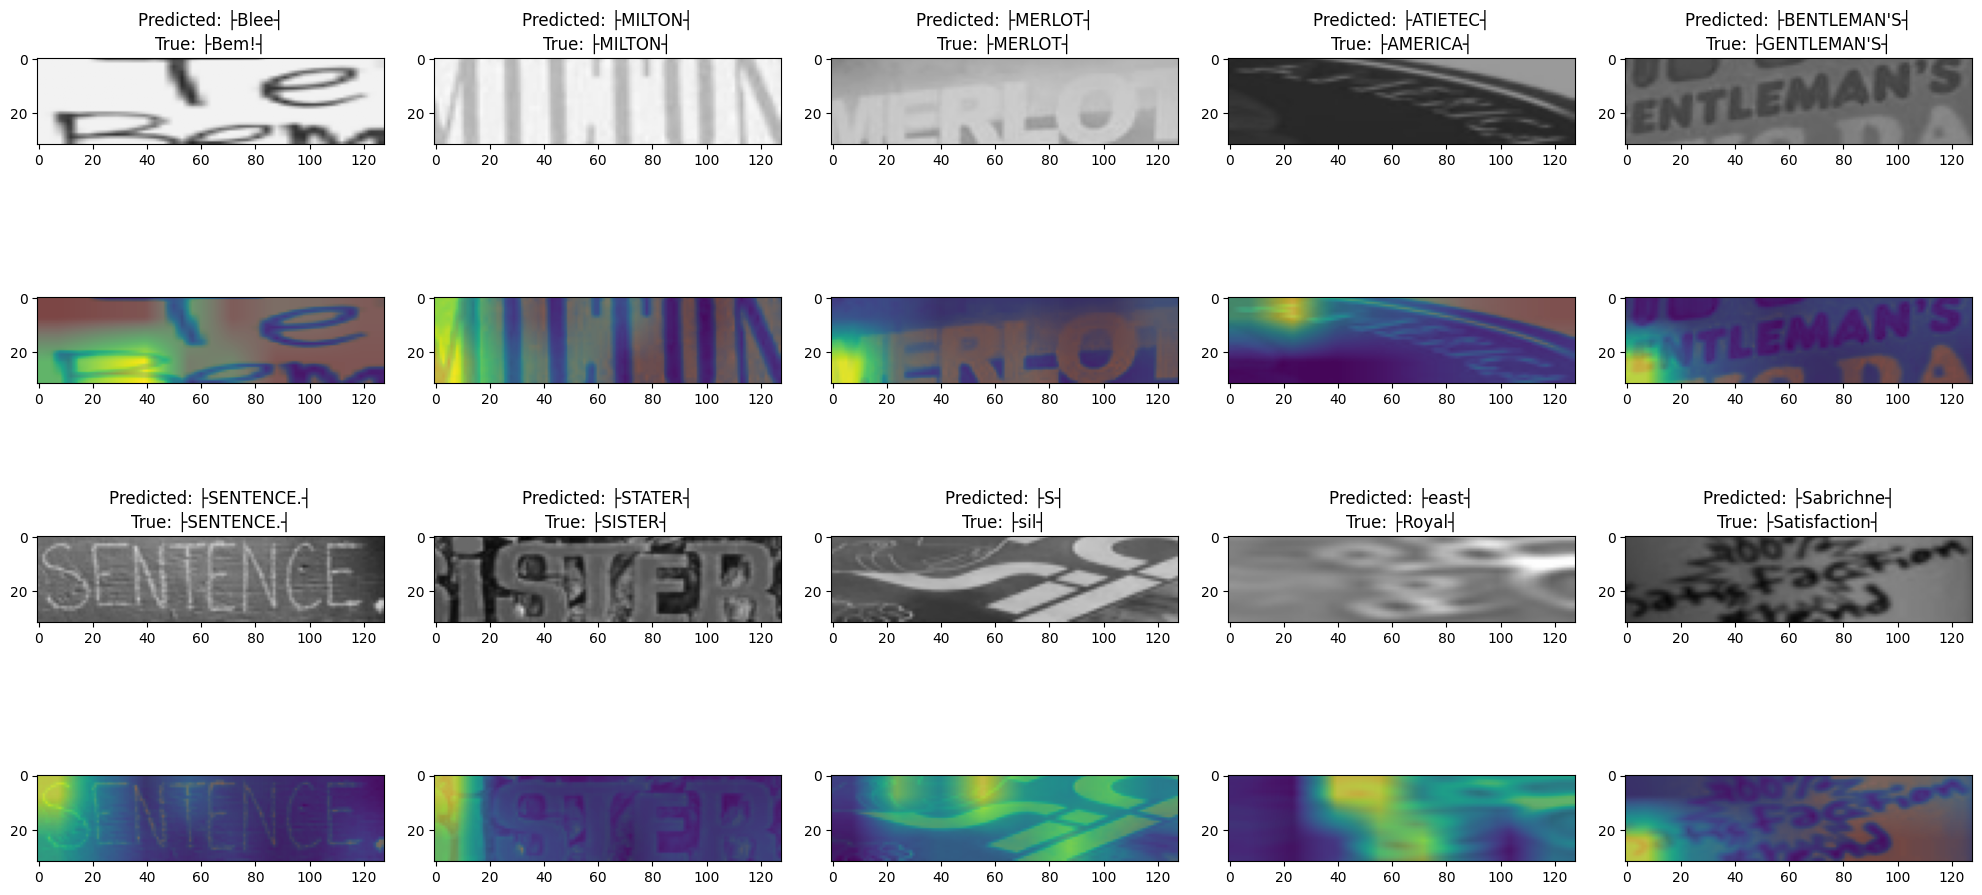

In [34]:
model.eval()
test_features, test_labels, _ = next(iter(test_dataloader))
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
b_idx = -1
i_end_token = encode(end_token)[0]
i_pad_token = encode(pad_token)[0]
for i in range(0, 4, 2):
    for j in range(5):
        b_idx += 1
        test_feature, test_label = test_features[b_idx], test_labels[b_idx]
        test_feature = test_feature.to(device)
        current_token = start_token
        current_de_string = torch.tensor(encode(start_token)[0], dtype=torch.long).view(1, 1)
        test_feature = test_feature.view(1, 1, 32, 128)
        idx = 0
        while current_token[0] != i_pad_token and current_token[0] != i_end_token and idx < 27:
            current_de_string.to(device)
            with torch.autocast('cuda'):
                predictions = model.forward(test_feature, current_de_string)
            predictions = nn.functional.softmax(predictions, dim=-1)
            current_token = torch.argmax(predictions, dim=-1)[:, idx].cpu()
            current_de_string = torch.cat([current_de_string, current_token.view(1, 1)], dim=-1)
            idx += 1
        axs[i, j].set_title(f"Predicted: {decode(current_de_string[0])}\nTrue: {trim_pad(decode(test_label))}")
        axs[i, j].imshow(make_it_cv2(test_feature[0].cpu()))
        plot_attn(axs[i + 1, j])
fig.tight_layout()
plt.savefig('/kaggle/working/fig3.png')
